# Visão Computacional e Deep Learning para Sensoriamento Remoto com Python


# Capítulo 17 - Segmentação semantica para mapeamento de Uso e Cobertura com Pytorch e TorchGeo

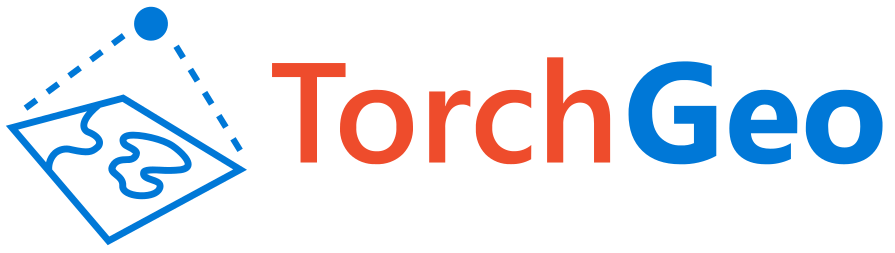

TorchGeo é uma biblioteca de domínio PyTorch que fornece conjuntos de dados, amostradores, transformações e modelos pré-treinados específicos para dados geoespaciais.

Em conjuntos de dados tradicionais de visão computacional, como o ImageNet, os próprios arquivos de imagem tendem a ser bastante simples e fáceis de trabalhar. A maioria das imagens possui 3 bandas espectrais (RGB), são armazenadas em formatos de arquivo comuns como PNG ou JPEG e podem ser facilmente carregadas com bibliotecas de software populares como PIL ou OpenCV. Cada imagem nesses conjuntos de dados geralmente é pequena o suficiente para passar diretamente para uma rede neural. Além disso, a maioria desses conjuntos de dados contém um número finito de imagens bem selecionadas que são consideradas independentes e distribuídas de forma idêntica, tornando simples as divisões train-val-test. Como resultado dessa relativa homogeneidade, os mesmos modelos pré-treinados (por exemplo, CNNs pré-treinados no ImageNet) mostraram-se eficazes em uma ampla gama de tarefas de visão usando métodos de aprendizagem por transferência. As bibliotecas existentes, como a torchvision, lidam bem com esses casos simples e têm sido usadas para fazer grandes avanços em tarefas de visão na última década.

As imagens de sensoriamento remoto não são tão uniformes. Em vez de imagens RGB simples, os satélites tendem a capturar imagens multiespectrais (o Landsat 8 possui 11 bandas espectrais) ou mesmo hiperespectrais (o Hyperion possui 242 bandas espectrais). Essas imagens capturam informações em uma faixa mais ampla de comprimentos de onda (400 nm–15 µm), muito fora do espectro visível. Diferentes satélites também têm resoluções espaciais muito diferentes – GOES tem uma resolução de 4 km/px, as imagens Maxar são de 30 cm/px e a resolução das imagens de drones pode chegar a 7 mm/px. Esses conjuntos de dados quase sempre têm um componente temporal, com revisões de satélite diárias, semanais ou quinzenais. As imagens geralmente se sobrepõem a outras imagens no conjunto de dados e precisam ser unidas com base em metadados geográficos. Essas imagens tendem a ser muito grandes (por exemplo, 10K x 10K pixels), portanto não é possível passar uma imagem inteira por uma rede neural. Esses dados são distribuídos em centenas de diferentes formatos de arquivos raster e vetoriais, como GeoTIFF e ESRI Shapefile, exigindo bibliotecas especializadas como GDAL para serem carregados.

TorchGeo foi projetado para ter a mesma API de outras bibliotecas de domínio PyTorch, como torchvision, torchtext e torchaudio. Se você já usa o torchvision em seu fluxo de trabalho para conjuntos de dados de visão computacional, você pode mudar para o TorchGeo alterando apenas algumas linhas de código. Todos os conjuntos de dados e amostradores TorchGeo são compatíveis com a classe PyTorch DataLoader, o que significa que você pode aproveitar as vantagens de bibliotecas wrapper como PyTorch Lightning para treinamento distribuído. Nas seções a seguir, exploraremos possíveis casos de uso do TorchGeo para mostrar como ele é simples de usar.

Vamos realizar a instalação:

In [ ]:
!pip install -q git+https://github.com/microsoft/torchgeo.git
!pip install -q GPUtil

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Vamos importar as funções e conectar com o Drive:

In [ ]:
import os
import tempfile

from torch.utils.data import DataLoader

from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

In [ ]:
import lightning.pytorch as pl # Instead of import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, RasterDataset
from torchgeo.datasets.splits import random_bbox_assignment
from torchgeo.samplers import RandomGeoSampler, RandomBatchGeoSampler, GridGeoSampler
import os
import matplotlib.pyplot as plt
import numpy as np
from torchgeo.trainers import SemanticSegmentationTask
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import ssl
import multiprocessing as mp
from torchgeo.datamodules import GeoDataModule
from typing import Type
import albumentations as A
import timeit
import torch
import numpy as np
from rasterio.plot import show
from rasterio.merge import merge
import rasterio
from rasterio.transform import from_bounds, from_origin
from rasterio.crs import CRS
from rasterio.io import MemoryFile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Chesapeake Land Cover

Este conjunto de dados contém imagens aéreas de alta resolução do programa USDA NAIP, rótulos de cobertura do solo de alta resolução da Chesapeake Conservancy, rótulos de cobertura do solo de baixa resolução do conjunto de dados USGS NLCD 2011, baixa resolução imagens multiespectrais do Landsat 8 e máscaras de pegada de edifícios de alta resolução do Microsoft Bing, formatadas para acelerar a pesquisa de aprendizado de máquina no mapeamento da cobertura do solo. A Chesapeake Conservancy gastou mais de 10 meses e US$ 1,3 milhão criando um conjunto consistente de dados de cobertura do solo de seis classes cobrindo a bacia hidrográfica da Baía de Chesapeake. Embora o objectivo do esforço de mapeamento da Chesapeake Conservancy fosse criar dados de cobertura do solo para serem utilizados em esforços de conservação, os mesmos dados podem ser utilizados para treinar modelos de aprendizagem automática que podem ser aplicados em áreas ainda mais vastas.

A organização deste conjunto de dados permitirá aos usuários testar facilmente questões relacionadas a este problema de generalização geográfica, ou seja, como treinar modelos de aprendizado de máquina que possam ser aplicados em áreas ainda mais amplas. Por exemplo, este conjunto de dados pode ser usado para estimar diretamente quão bem um modelo treinado em dados de Maryland pode generalizar para o restante da Baía de Chesapeake.

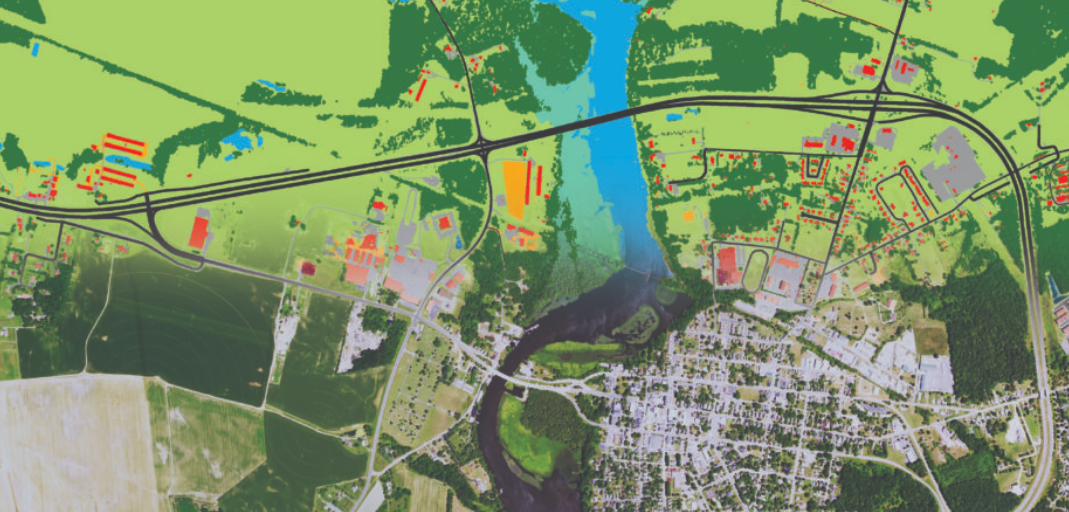

O dataset consiste de quatro ortomosaicos NAIP e quatro arquivos representando as labels:

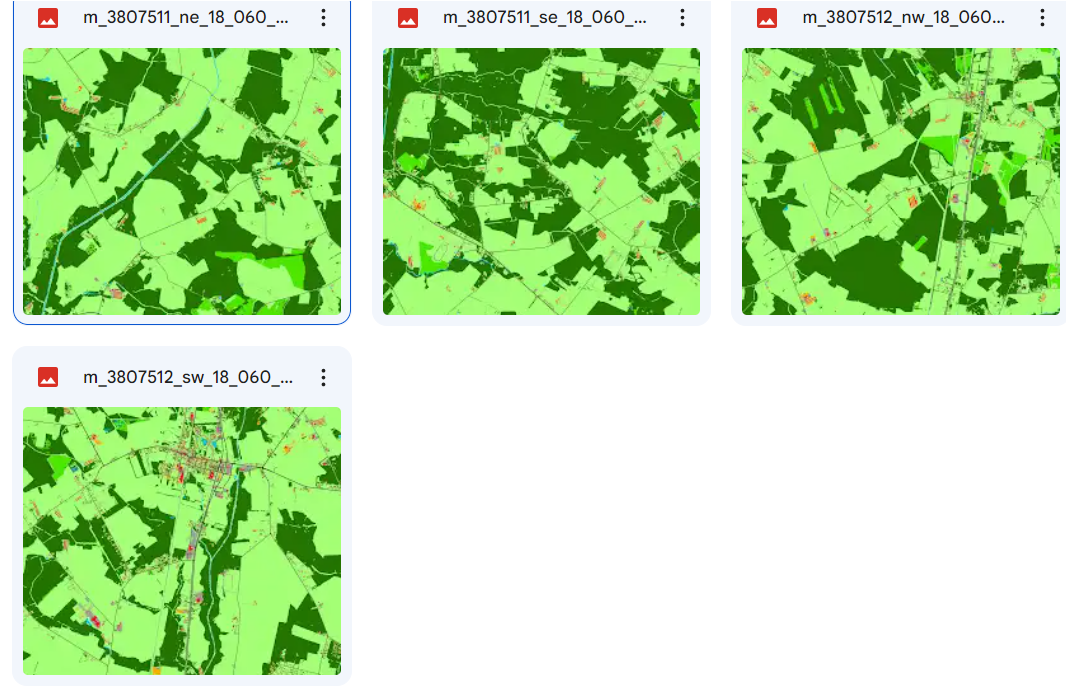

Podemos definir as classes do dataset de acordo com o mapa de cores e dos códigos da documentação:

In [ ]:
"""
Complete 13-class dataset.

    This version of the dataset is composed of 13 classes:

    0. No Data: Background values
    1. Water: All areas of open water including ponds, rivers, and lakes
    2. Wetlands: Low vegetation areas located along marine or estuarine regions
    3. Tree Canopy: Deciduous and evergreen woody vegetation over 3-5 meters in height
    4. Shrubland: Heterogeneous woody vegetation including shrubs and young trees
    5. Low Vegetation: Plant material less than 2 meters in height including lawns
    6. Barren: Areas devoid of vegetation consisting of natural earthen material
    7. Structures: Human-constructed objects made of impervious materials
    8. Impervious Surfaces: Human-constructed surfaces less than 2 meters in height
    9. Impervious Roads: Impervious surfaces that are used for transportation
    10. Tree Canopy over Structures: Tree cover overlapping impervious structures
    11. Tree Canopy over Impervious Surfaces: Tree cover overlapping impervious surfaces
    12. Tree Canopy over Impervious Roads: Tree cover overlapping impervious roads
    13. Aberdeen Proving Ground: U.S. Army facility with no labels
"""

names=[
    'No Data',
    'Water',
    'Wetlands',
    'Tree Canopy',
    'Shrubland',
    'Low Vegetation',
    'Barren',
    'Structures',
    'Impervious Surfaces',
    'Impervious Roads',
    'Tree Canopy over Structures',
    'Tree Canopy over Impervious Surfaces',
    'Tree Canopy over Impervious Roads',
    'Aberdeen Proving Ground',
]

# subclasses use the 13 class cmap by default
cmap = [
    (0, 0, 0, 0),
    (0, 197, 255, 255),
    (0, 168, 132, 255),
    (38, 115, 0, 255),
    (76, 230, 0, 255),
    (163, 255, 115, 255),
    (255, 170, 0, 255),
    (255, 0, 0, 255),
    (156, 156, 156, 255),
    (0, 0, 0, 255),
    (115, 115, 0, 255),
    (230, 230, 0, 255),
    (255, 255, 115, 255),
    (197, 0, 255, 255),
]

Vamos definir também a arquitetura e seus parâmetros:

In [ ]:
EPOCHS = 15
LR = 1e-4

IN_CHANNELS = 4 # NAIP dataset has 4 bands
NUM_CLASSES = len(names) # Chesapeake dataset has 13 classes
IMG_SIZE = 256
BATCH_SIZE = 8
SAMPLE_SIZE = 500

PATIENCE = 5
SEGMENTATION_MODEL = 'deeplabv3+' # only supports 'unet', 'deeplabv3+' and 'fcn'
#BACKBONE = 'se_resnet50'
BACKBONE = 'resnet50' # supports TIMM encoders (https://smp.readthedocs.io/en/latest/encoders_timm.html)
WEIGHTS = 'imagenet'
LOSS = 'focal' # supports ‘ce’, ‘jaccard’ or ‘focal’ loss


DEVICE, NUM_DEVICES = ("cuda", torch.cuda.device_count()) if torch.cuda.is_available() else ("cpu", mp.cpu_count())
WORKERS = mp.cpu_count()
print(f'Running on {NUM_DEVICES} {DEVICE}(s)')

Running on 1 cuda(s)


Então, definimos o caminho do dataset e instanciamos a tarefa de segmentação semântica:

In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context

OUTPUT_DIR = '/content/'
INPUT_DIR = '/content/drive/MyDrive/Datasets/Naip_chesapeak'

TEST_DIR = os.path.join(OUTPUT_DIR, "test")
if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)

logger = CSVLogger(
    TEST_DIR,
    name='torchgeo_logs'
)

checkpoint_callback = ModelCheckpoint(
    every_n_epochs=1,
    dirpath=TEST_DIR,
    filename='torchgeo_trained'
)

task = SemanticSegmentationTask(
    model = SEGMENTATION_MODEL,
    backbone = BACKBONE,
    weights = True, # to use imagenet. Before we should define weights='imagenet'
    in_channels = IN_CHANNELS,
    num_classes = NUM_CLASSES,
    loss = LOSS,
    ignore_index = None,
    learning_rate = LR,
    learning_rate_schedule_patience = PATIENCE,
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.2MB/s]


Também definimos uma função para executar o treinamento:

In [ ]:
trainer = pl.Trainer(
        accelerator=DEVICE,
        devices=NUM_DEVICES,
        max_epochs=EPOCHS,
        callbacks=[checkpoint_callback, ],
        logger=logger,
    )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Vamos iniciar o carregamento dos dados. Primeiro criamos as classes para a Imagens e para os Labels:

In [ ]:
class NAIPImages(RasterDataset):
    filename_glob = "m_*.tif"
    is_image = True
    separate_files = False

class ChesapeakeLabels(RasterDataset):
    filename_glob = "m_*.tif"
    is_image = False
    separate_files = False

Depois criamos um aumento de dados e carregamos os dados de imagens e labels:

In [ ]:
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.RandomBrightness(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

naip_root = os.path.join(INPUT_DIR, 'naip_images')
naip_images = NAIPImages(
    root=naip_root,
    #transforms=data_augmentation_transform,
)
print(naip_images)

chesapeake_root = os.path.join(INPUT_DIR, "chesapeake_labels")
chesapeake_labels = ChesapeakeLabels(
    root=chesapeake_root,
    #transforms=data_augmentation_transform,
)
print(chesapeake_labels)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


NAIPImages Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=440002.8, maxx=451549.7999999998, miny=4288884.0, maxy=4303429.2, mint=0.0, maxt=9.223372036854776e+18)
    size: 4
ChesapeakeLabels Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=440002.9842051893, maxx=451549.3842051893, miny=4288884.327921044, maxy=4303428.927921044, mint=0.0, maxt=9.223372036854776e+18)
    size: 4


Desta maneira, juntamos os datasets de imagens e labels e aplicamos um sampler que irá gerar patches de acordo com o tamanho e quantidade de amostras que definimos anteriormente.

In [ ]:
dataset = naip_images & chesapeake_labels # this means I'm creating an IntersectionDataset
sampler = RandomGeoSampler(dataset, size=IMG_SIZE, length=SAMPLE_SIZE)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

Converting ChesapeakeLabels res from 0.6000000000000023 to 0.6


Vamos agora criar a classe do dataset completo que irá criar a divisão dos dados em treinamento, teste e validação:

In [ ]:
class CustomGeoDataModule(GeoDataModule):
    def setup(self, stage: str) -> None:
        """Set up datasets.

        Args:
            stage: Either 'fit', 'validate', 'test', or 'predict'.
        """
        self.dataset = self.dataset_class(**self.kwargs)

        generator = torch.Generator().manual_seed(0)
        (
            self.train_dataset,
            self.val_dataset,
            self.test_dataset,
        ) = random_bbox_assignment(dataset, [0.6, 0.2, 0.2], generator)

        if stage in ["fit"]:
            self.train_batch_sampler = RandomBatchGeoSampler(
                self.train_dataset, self.patch_size, self.batch_size, self.length
            )
        if stage in ["fit", "validate"]:
            self.val_sampler = GridGeoSampler(
                self.val_dataset, self.patch_size, self.patch_size
            )
        if stage in ["test"]:
            self.test_sampler = GridGeoSampler(
                self.test_dataset, self.patch_size, self.patch_size
            )

datamodule = CustomGeoDataModule(
    dataset_class = type(dataset), # GeoDataModule kwargs
    batch_size = BATCH_SIZE, # GeoDataModule kwargs
    patch_size = IMG_SIZE, # GeoDataModule kwargs
    length = SAMPLE_SIZE, # GeoDataModule kwargs
    num_workers = WORKERS, # GeoDataModule kwargs
    dataset1 = naip_images, # IntersectionDataset kwargs
    dataset2 = chesapeake_labels, # IntersectionDataset kwargs
    collate_fn = stack_samples, # IntersectionDataset kwargs
)

Podemos visualizar alguns exemplos de imagens e labels geradas:

In [ ]:
def colour_code_segmentation(image, colors):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        colormap: the list os rgb colors for each class

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(colors)
    return colour_codes[image]

In [ ]:
import torchvision.transforms as transforms
reverse_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size=IMG_SIZE),
        ])

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

n = 0
for sample in dataloader:
    if n == 10:
        break
    image, gt_mask = sample['image'], sample['mask']

    gt_mask = colour_code_segmentation(gt_mask, cmap)

    visualize(
        image=reverse_transform(image.squeeze()[:3]),
        ground_truth = gt_mask.squeeze(),
    )
    n += 1

Com tudo pronto, vamos executar o treinamento e a validação do modelo:

In [ ]:
start = timeit.default_timer() # Measuring the time

checkpoint_file = os.path.join(TEST_DIR, 'torchgeo_trained.ckpt')

if os.path.isfile(checkpoint_file):
    print('Resuming training from previous checkpoint...')
    trainer.fit(
        model=task,
        datamodule=datamodule,
        ckpt_path=checkpoint_file
    )
else:
    print('Starting training from scratch...')
    trainer.fit(
        model=task,
        datamodule = datamodule,
    )

print("The time taken to train was: ", timeit.default_timer() - start)

Starting training from scratch...


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/test exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | DeepLabV3Plus    | 26.7 M
1 | loss          | FocalLoss        | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
26.7 M    Trainable params
0         Non-trainable params
26.7 M    Total params
106.736   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


The time taken to train was:  338.4465540860001


Depois de treinado, vamos aplicar aos dados de teste:

In [ ]:
trainer.test(
    model=task,
    datamodule=datamodule
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_MulticlassAccuracy   │     0.8992854952812195      │
│ test_MulticlassJaccardIndex │     0.8170016407966614      │
│          test_loss          │    8.787868864601478e-06    │
└─────────────────────────────┴─────────────────────────────┘

[{'test_loss': 8.787868864601478e-06,
  'test_MulticlassAccuracy': 0.8992854952812195,
  'test_MulticlassJaccardIndex': 0.8170016407966614}]

Depois de treinado e validado, vamos usar um dos ortomoaiscos NAIP para fazer a predição completa. Primeiro carregamos o ortomosaico, dividimos em patches e realizamos a predição para cada patche. Depois aplicamos um Merge nos patches predictos e geramos o resultado georreferênciado:

In [ ]:
def create_in_memory_geochip(predicted_chip, geotransform, crs):
    """
    Apply georeferencing to the predicted chip.

    Parameters:
        predicted_chip (numpy array): The predicted segmentation chip (e.g., binary mask).
        geotransform (tuple): A tuple containing the geotransformation information of the chip (x-coordinate of the top left corner, x and y pixel size, rotation, y-coordinate of the top left corner, and rotation).
        crs (str): Spatial Reference System (e.g., EPSG code) of the chip.

    Return:
        A rasterio dataset that is georreferenced.
    """
    memfile = MemoryFile()
    dataset = memfile.open(
        driver='GTiff',
        height=predicted_chip.shape[0],
        width=predicted_chip.shape[1],
        count=predicted_chip.shape[2],  # Number of bands
        dtype=np.uint8,
        crs=crs,
        transform=geotransform,
        photometric='RGBA',
    )

    rolled_array = np.rollaxis(predicted_chip, axis=2) # putting the bands first
    dataset.write(rolled_array)
    return dataset

In [ ]:
def georreferenced_chip_generator(dataloader, model, crs, pixel_size, colors):
    """
    Apply georeferencing to the predicted chip.

    Parameters:
        dataloader (torch.utils.data.Dataloader): Dataloader with the data to be predicted.
        model (an https://github.com/qubvel/segmentation_models.pytorch model): model used for inference.
        crs (str): Spatial Reference System (e.g., EPSG code) of the chip.
        pixel_size (float): Pixel dimensoion in map units.

    Yields:
        A georeferenced numpy array of the predicted output.
    """
    georref_chips_list = []
    for i, sample in enumerate(dataloader):
        '''
        if i == 10:
            break
        '''

        image, gt_mask, bbox = sample['image'], sample['mask'], sample['bbox'][0]

        image = image/255. # as I'm not using a GeoDatamodule, I need to divide de images by 255 manually

        prediction = model.predict(image)
        prediction = torch.softmax(prediction, dim=1)
        prediction = torch.argmax(prediction, dim = 1)

        # reapplying the original colors in the reversed one hot images
        #gt_mask = colour_code_segmentation(gt_mask, colors)
        prediction = colour_code_segmentation(prediction, colors)

        geotransform = from_origin(bbox.minx, bbox.maxy, pixel_size, pixel_size)
        #yield create_in_memory_geochip(prediction.squeeze(), geotransform, crs)
        georref_chips_list.append(create_in_memory_geochip(prediction.squeeze(), geotransform, crs))
    return georref_chips_list

In [ ]:
def merge_georeferenced_chips(chips_generator, output_path):
    """
    Merge a list of georeferenced chips into a single GeoTIFF file.

    Parameters:
        chips_generator (generator): A generator of Rasterio datasets representing the georeferenced chips.
        output_path (str): The path where the merged GeoTIFF file will be saved.

    Returns:
        None
    """
    #chips_list = list(chips_generator)
    chips_list = chips_generator
    # Merge the chips using Rasterio's merge function
    merged, merged_transform = merge(chips_list)

    # Calculate the number of rows and columns for the merged output
    rows, cols = merged.shape[1], merged.shape[2]

    # Update the metadata of the merged dataset
    merged_metadata = chips_list[0].meta
    merged_metadata.update({
        'height': rows,
        'width': cols,
        'transform': merged_transform
    })

    # Write the merged array to a new GeoTIFF file
    with rasterio.open(output_path, 'w', **merged_metadata) as dst:
        dst.write(merged)

    for chip in chips_list:
        chip.close()

In [ ]:
test_dataset = datamodule.test_dataset
test_sampler = GridGeoSampler(test_dataset, 2048, 2048)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, collate_fn=stack_samples)

pixel_size = test_dataset.res
crs = test_dataset.crs.to_epsg()

start = timeit.default_timer() # Measuring the time
chips_generator = georreferenced_chip_generator(test_dataloader, task.model, crs, pixel_size, cmap)
print("The time taken to predict was: ", timeit.default_timer() - start)

start = timeit.default_timer() # Measuring the time
file_name = os.path.join(OUTPUT_DIR, 'merged_prediction.tif')
merge_georeferenced_chips(chips_generator, file_name)
print("The time taken to generate a georrefenced image and save it was: ", timeit.default_timer() - start)

The time taken to predict was:  418.4003023790001
The time taken to generate a georrefenced image and save it was:  4.671972782000012


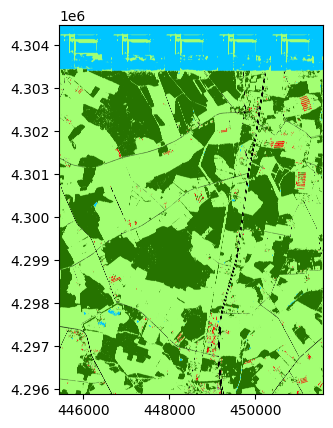

<Axes: >

In [ ]:
output_filepath = os.path.join(OUTPUT_DIR, 'merged_prediction.tif')
src = rasterio.open(output_filepath)
show(src.read(), transform=src.transform)

Referencia:

https://www.kaggle.com/code/luizclaudioandrade/torchgeo-101

https://torchgeo.readthedocs.io/en/stable/tutorials/getting_started.html

https://pytorch.org/blog/geospatial-deep-learning-with-torchgeo/